# 🫁 Respiratory Disease Classification using Vanilla RNN

This notebook implements a vanilla RNN-based model for classifying respiratory diseases from cough and vowel audio.

**Classes:**
- 0: Healthy
- 1: COPD
- 2: Asthma

**Model Architecture:**
- Bidirectional Vanilla RNN with Attention mechanism
- MFCC + Delta + Delta-Delta features
- Data Augmentation (noise, shift, speed, gain)
- Mixup Augmentation

**Note:** Vanilla RNN is simpler than LSTM/GRU but may struggle with long sequences due to vanishing gradients.

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    fbeta_score, classification_report, confusion_matrix
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Configuration

In [2]:
class Config:
    """Configuration for the Vanilla RNN respiratory disease classifier"""
    
    # Paths
    BASE_PATH = Path('/mnt/ml_storage/Final_Project/SOURCE2')
    TRAIN_CSV = BASE_PATH / 'train.csv'
    TEST_CSV = BASE_PATH / 'test.csv'
    COUGH_PATH = BASE_PATH / 'dataclean_cough_1'
    VOWEL_PATH = BASE_PATH / 'dataclean_vowel_1'
    MODEL_DIR = BASE_PATH / 'models'
    
    # Audio parameters - shorter duration for vanilla RNN (helps with vanishing gradients)
    SAMPLE_RATE = 16000
    DURATION = 1.5  # shorter than LSTM/GRU due to vanishing gradient issues
    N_MFCC = 20
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MELS = 64
    
    # Feature parameters
    INPUT_SIZE = N_MFCC * 3  # MFCC + delta + delta-delta = 60 features
    COMBINE_MODE = "concat"  # concat, average, cough_only, vowel_only
    
    # Vanilla RNN Model parameters
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.4
    OUTPUT_SIZE = 3  # 3 classes
    RNN_NONLINEARITY = 'tanh'  # 'tanh' or 'relu'
    
    # Training parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 150
    LEARNING_RATE = 0.0003  # Lower LR for vanilla RNN stability
    WEIGHT_DECAY = 1e-3
    PATIENCE = 25
    VAL_SPLIT = 0.2
    GRADIENT_CLIP = 0.5  # Stricter gradient clipping for vanilla RNN
    
    # Augmentation
    USE_AUGMENTATION = True
    MIXUP_ALPHA = 0.2

config = Config()

# Create model directory
config.MODEL_DIR.mkdir(exist_ok=True)

print("Vanilla RNN Configuration:")
print(f"  Audio: {config.SAMPLE_RATE}Hz, {config.DURATION}s, {config.N_MFCC} MFCCs")
print(f"  Features: {config.INPUT_SIZE} per audio type")
print(f"  RNN: hidden={config.HIDDEN_SIZE}, layers={config.NUM_LAYERS}, bidirectional={config.BIDIRECTIONAL}")
print(f"  RNN nonlinearity: {config.RNN_NONLINEARITY}")
print(f"  Training: batch={config.BATCH_SIZE}, lr={config.LEARNING_RATE}, epochs={config.NUM_EPOCHS}")
print(f"  Gradient clip: {config.GRADIENT_CLIP}")
print(f"  Augmentation: {config.USE_AUGMENTATION}, mixup_alpha={config.MIXUP_ALPHA}")

Vanilla RNN Configuration:
  Audio: 16000Hz, 1.5s, 20 MFCCs
  Features: 60 per audio type
  RNN: hidden=128, layers=2, bidirectional=True
  RNN nonlinearity: tanh
  Training: batch=16, lr=0.0003, epochs=150
  Gradient clip: 0.5
  Augmentation: True, mixup_alpha=0.2


## 3. Load Data

In [3]:
# Load training and test data
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Check class distribution
print(f"\nClass distribution:")
print(train_df['disease'].value_counts().sort_index())

# Compute class weights
def compute_class_weights(labels, method='sqrt'):
    """Compute class weights for imbalanced data"""
    unique_classes = np.unique(labels)
    class_counts = np.bincount(labels.astype(int))
    
    if method == 'sqrt':
        class_weights = np.sqrt(1.0 / class_counts)
    elif method == 'inverse':
        class_weights = 1.0 / class_counts
    else:
        class_weights = np.ones(len(unique_classes))
    
    class_weights = class_weights / class_weights.sum() * len(unique_classes)
    
    print(f"\nClass weights ({method}):")
    for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
        class_name = ['Healthy', 'COPD', 'Asthma'][i]
        print(f"  Class {i} ({class_name}): count={count}, weight={weight:.4f}")
    
    return torch.FloatTensor(class_weights)

Training samples: 546
Test samples: 338

Class distribution:
disease
0    140
1    238
2    168
Name: count, dtype: int64


## 4. Dataset Class with Augmentation

In [4]:
class RespiratoryDataset(Dataset):
    """Dataset that combines cough and vowel audio features with augmentation"""
    
    def __init__(self, candidate_ids, labels, config, is_test=False, augment=False):
        self.candidate_ids = candidate_ids
        self.labels = labels
        self.config = config
        self.is_test = is_test
        self.augment = augment and not is_test
        self.cough_path = config.COUGH_PATH
        self.vowel_path = config.VOWEL_PATH
    
    def __len__(self):
        return len(self.candidate_ids)
    
    def _augment_audio(self, audio):
        """Apply random audio augmentations"""
        if not self.augment or np.random.random() > 0.5:
            return audio
        
        aug_type = np.random.choice(['noise', 'shift', 'speed', 'gain'])
        
        if aug_type == 'noise':
            noise_factor = np.random.uniform(0.001, 0.005)
            noise = np.random.randn(len(audio)) * noise_factor
            audio = audio + noise
        elif aug_type == 'shift':
            shift_max = int(len(audio) * 0.1)
            shift = np.random.randint(-shift_max, shift_max)
            audio = np.roll(audio, shift)
        elif aug_type == 'speed':
            speed_factor = np.random.uniform(0.95, 1.05)
            audio = librosa.effects.time_stretch(audio, rate=speed_factor)
            target_len = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_len:
                audio = audio[:target_len]
            else:
                audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
        elif aug_type == 'gain':
            gain_factor = np.random.uniform(0.8, 1.2)
            audio = audio * gain_factor
        
        return audio
    
    def _load_and_extract_features(self, audio_path):
        """Load audio and extract MFCC features"""
        try:
            audio, sr = librosa.load(audio_path, sr=self.config.SAMPLE_RATE)
            
            target_samples = int(self.config.SAMPLE_RATE * self.config.DURATION)
            if len(audio) > target_samples:
                audio = audio[:target_samples]
            else:
                audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
            
            if self.augment:
                audio = self._augment_audio(audio)
            
            mfcc = librosa.feature.mfcc(
                y=audio,
                sr=self.config.SAMPLE_RATE,
                n_mfcc=self.config.N_MFCC,
                n_fft=self.config.N_FFT,
                hop_length=self.config.HOP_LENGTH,
                n_mels=self.config.N_MELS
            )
            
            delta = librosa.feature.delta(mfcc)
            delta_delta = librosa.feature.delta(mfcc, order=2)
            
            features = np.vstack([mfcc, delta, delta_delta])
            features = features.T
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
            features = np.clip(features, -1e6, 1e6)
            
            return features
            
        except Exception as e:
            print(f"Error loading {audio_path}: {str(e)}")
            expected_frames = int((self.config.SAMPLE_RATE * self.config.DURATION) / self.config.HOP_LENGTH) + 1
            return np.zeros((expected_frames, self.config.INPUT_SIZE))
    
    def __getitem__(self, idx):
        candidate_id = self.candidate_ids[idx]
        
        cough_audio_path = self.cough_path / candidate_id / 'cough.wav'
        vowel_audio_path = self.vowel_path / candidate_id / 'vowel.wav'
        
        cough_features = self._load_and_extract_features(cough_audio_path)
        vowel_features = self._load_and_extract_features(vowel_audio_path)
        
        if self.config.COMBINE_MODE == "concat":
            combined = np.concatenate([cough_features, vowel_features], axis=1)
        elif self.config.COMBINE_MODE == "average":
            combined = (cough_features + vowel_features) / 2.0
        elif self.config.COMBINE_MODE == "cough_only":
            combined = cough_features
        elif self.config.COMBINE_MODE == "vowel_only":
            combined = vowel_features
        else:
            raise ValueError(f"Unknown combine_mode: {self.config.COMBINE_MODE}")
        
        audio_tensor = torch.FloatTensor(combined)
        
        if self.is_test:
            return audio_tensor, candidate_id
        else:
            label = torch.LongTensor([self.labels[idx]])[0]
            return audio_tensor, label, candidate_id


def collate_fn(batch):
    """Collate function to handle variable-length sequences"""
    if len(batch[0]) == 2:
        audio_features = [item[0] for item in batch]
        candidate_ids = [item[1] for item in batch]
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        return audio_padded, lengths, candidate_ids
    else:
        audio_features = [item[0] for item in batch]
        labels = torch.stack([item[1] for item in batch])
        candidate_ids = [item[2] for item in batch]
        audio_padded = nn.utils.rnn.pad_sequence(audio_features, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in audio_features])
        return audio_padded, lengths, labels, candidate_ids


print("Dataset class defined!")

Dataset class defined!


## 5. Vanilla RNN Model with Attention

In [5]:
class RespiratoryRNN(nn.Module):
    """Vanilla RNN-based model for respiratory disease classification with attention mechanism"""
    
    def __init__(self, config):
        super(RespiratoryRNN, self).__init__()
        
        self.config = config
        self.hidden_size = config.HIDDEN_SIZE
        self.num_layers = config.NUM_LAYERS
        self.bidirectional = config.BIDIRECTIONAL
        
        # Calculate actual input size based on combine mode
        if config.COMBINE_MODE == "concat":
            input_size = config.INPUT_SIZE * 2  # 120 features (60 cough + 60 vowel)
        else:
            input_size = config.INPUT_SIZE  # 60 features
        
        # Input batch normalization
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # Vanilla RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=config.HIDDEN_SIZE,
            num_layers=config.NUM_LAYERS,
            batch_first=True,
            dropout=config.DROPOUT if config.NUM_LAYERS > 1 else 0,
            bidirectional=config.BIDIRECTIONAL,
            nonlinearity=config.RNN_NONLINEARITY
        )
        
        # Calculate RNN output size
        rnn_output_size = config.HIDDEN_SIZE * 2 if config.BIDIRECTIONAL else config.HIDDEN_SIZE
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(rnn_output_size, rnn_output_size // 2),
            nn.Tanh(),
            nn.Linear(rnn_output_size // 2, 1)
        )
        
        # Classification head with residual connection concept
        self.classifier = nn.Sequential(
            nn.Linear(rnn_output_size, config.HIDDEN_SIZE),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE, config.HIDDEN_SIZE // 2),
            nn.ReLU(),
            nn.BatchNorm1d(config.HIDDEN_SIZE // 2),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_SIZE // 2, config.OUTPUT_SIZE)
        )
    
    def forward(self, audio_features, lengths):
        batch_size = audio_features.size(0)
        
        # Apply batch normalization
        audio_features_transposed = audio_features.transpose(1, 2)
        audio_features_normed = self.batch_norm_input(audio_features_transposed)
        audio_features = audio_features_normed.transpose(1, 2)
        
        # Pack padded sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(
            audio_features, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # RNN forward pass
        packed_output, hidden = self.rnn(packed_input)
        
        # Unpack sequences
        rnn_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply attention mechanism
        attention_weights = self.attention(rnn_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted sum using attention
        attended_output = torch.sum(rnn_output * attention_weights, dim=1)
        
        # Classification
        logits = self.classifier(attended_output)
        
        return logits
    
    def _init_weights(self):
        """Initialize weights to avoid initial bias and help with vanishing gradients"""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                # Input-hidden weights: Xavier initialization
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                # Hidden-hidden weights: Orthogonal initialization (helps with vanishing gradients)
                nn.init.orthogonal_(param)
            elif 'weight' in name:
                if 'bn' in name or 'batch_norm' in name:
                    nn.init.ones_(param)
                elif len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # Initialize final layer with small weights
        final_layer = self.classifier[-1]
        nn.init.xavier_uniform_(final_layer.weight, gain=0.1)
        nn.init.zeros_(final_layer.bias)


print("Vanilla RNN Model class defined!")

Vanilla RNN Model class defined!


## 6. Training Functions

In [6]:
def mixup_data(x, y, alpha=0.2):
    """Apply Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute Mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_epoch(model, dataloader, criterion, optimizer, device, config, use_mixup=False):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    for audio, lengths, labels, _ in progress_bar:
        audio = audio.to(device)
        labels = labels.to(device)
        
        if torch.isnan(audio).any():
            continue
        
        # Apply Mixup
        if use_mixup and config.MIXUP_ALPHA > 0:
            audio, labels_a, labels_b, lam = mixup_data(audio, labels, config.MIXUP_ALPHA)
        
        optimizer.zero_grad()
        outputs = model(audio, lengths)
        
        if torch.isnan(outputs).any():
            print("Warning: NaN in outputs, skipping batch")
            continue
        
        # Compute loss
        if use_mixup and config.MIXUP_ALPHA > 0:
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            all_labels.extend(labels_a.cpu().numpy())
        else:
            loss = criterion(outputs, labels)
            all_labels.extend(labels.cpu().numpy())
        
        if torch.isnan(loss):
            print("Warning: NaN loss, skipping batch")
            continue
        
        loss.backward()
        
        # Stricter gradient clipping for vanilla RNN
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRADIENT_CLIP)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0.0
    
    unique_preds, pred_counts = np.unique(all_preds, return_counts=True)
    pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    return avg_loss, accuracy, pred_dist


def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for audio, lengths, labels, _ in tqdm(dataloader, desc="Validation"):
            audio = audio.to(device)
            labels = labels.to(device)
            
            outputs = model(audio, lengths)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels, all_probs


def evaluate_model(y_true, y_pred, title="Evaluation"):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = fbeta_score(y_true, y_pred, beta=1, average='weighted', zero_division=0)
    f1_macro = fbeta_score(y_true, y_pred, beta=1, average='macro', zero_division=0)
    
    print(f"\nMetrics:")
    print(f"  Accuracy:       {acc:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  F1 (weighted):  {f1:.4f}")
    print(f"  F1 (macro):     {f1_macro:.4f}")
    
    print(f"\nClassification Report:")
    class_names = ['Healthy', 'COPD', 'Asthma']
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1,
        'f1_macro': f1_macro,
        'confusion_matrix': cm
    }


print("Training functions defined!")

Training functions defined!


## 7. Prepare Data

In [7]:
# Filter out samples with missing audio files
print("Filtering out samples with missing audio files...")

def check_audio_exists(candidate_id, config):
    """Check if both cough and vowel audio files exist"""
    cough_path = config.COUGH_PATH / candidate_id / 'cough.wav'
    vowel_path = config.VOWEL_PATH / candidate_id / 'vowel.wav'
    return cough_path.exists() and vowel_path.exists()

# Filter training data
original_train_count = len(train_df)
train_df['has_audio'] = train_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
train_df_filtered = train_df[train_df['has_audio']].copy()
removed_train = original_train_count - len(train_df_filtered)

print(f"Training: {original_train_count} -> {len(train_df_filtered)} (removed {removed_train} with missing files)")

# Filter test data
original_test_count = len(test_df)
test_df['has_audio'] = test_df['candidateID'].apply(lambda x: check_audio_exists(x, config))
test_missing_ids = test_df[~test_df['has_audio']]['candidateID'].tolist()
print(f"Test: {original_test_count} total, {len(test_missing_ids)} with missing files")

# Use filtered training data
train_df = train_df_filtered

# Check class distribution after filtering
print(f"\nClass distribution after filtering:")
print(train_df['disease'].value_counts().sort_index())

# Split training data
train_ids = train_df['candidateID'].values
train_labels = train_df['disease'].values

train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_ids, train_labels, 
    test_size=config.VAL_SPLIT, 
    random_state=42,
    stratify=train_labels
)

print(f"\nData split:")
print(f"  Training: {len(train_ids)}")
print(f"  Validation: {len(val_ids)}")
print(f"  Test: {len(test_df)}")

# Create datasets
print("\nCreating datasets...")
train_dataset = RespiratoryDataset(train_ids, train_labels, config, is_test=False, augment=config.USE_AUGMENTATION)
val_dataset = RespiratoryDataset(val_ids, val_labels, config, is_test=False, augment=False)
test_dataset = RespiratoryDataset(test_df['candidateID'].values, None, config, is_test=True, augment=False)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=0, pin_memory=torch.cuda.is_available()
)

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Filtering out samples with missing audio files...
Training: 546 -> 533 (removed 13 with missing files)
Test: 338 total, 2 with missing files

Class distribution after filtering:
disease
0    137
1    238
2    158
Name: count, dtype: int64

Data split:
  Training: 426
  Validation: 107
  Test: 338

Creating datasets...

Dataloaders created:
  Train batches: 27
  Val batches: 7
  Test batches: 22


## 8. Initialize Model & Training

In [8]:
# Initialize Vanilla RNN model
print("Initializing Vanilla RNN model...")
model = RespiratoryRNN(config).to(device)
model._init_weights()
print("✓ Applied balanced weight initialization")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Compute class weights
class_weights = compute_class_weights(train_labels, method='sqrt')
class_weights = class_weights.to(device)

# Loss function
print("\nUsing CrossEntropyLoss with sqrt class weights")
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer - using Adam with lower learning rate for stability
optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

Initializing Vanilla RNN model...
✓ Applied balanced weight initialization

Model Architecture:
RespiratoryRNN(
  (batch_norm_input): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(120, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters: 237,

## 9. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rate': []
}

best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0
best_f1 = 0

print(f"\nStarting Vanilla RNN training for {config.NUM_EPOCHS} epochs...")
print(f"Using learning rate: {config.LEARNING_RATE}")
print(f"Gradient clipping: {config.GRADIENT_CLIP}")

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Training phase with mixup
    train_loss, train_acc, train_pred_dist = train_epoch(
        model, train_loader, criterion, optimizer, device, config, 
        use_mixup=config.USE_AUGMENTATION
    )
    
    # Validation phase
    val_loss, val_acc, val_preds, val_labels_epoch, val_probs = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Calculate F1 score
    val_f1 = fbeta_score(val_labels_epoch, val_preds, beta=1, average='macro', zero_division=0)
    
    # Prediction distribution
    unique_preds, pred_counts = np.unique(val_preds, return_counts=True)
    val_pred_dist = {int(cls): int(cnt) for cls, cnt in zip(unique_preds, pred_counts)}
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print results
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Train Preds: Class 0={train_pred_dist.get(0,0)}, Class 1={train_pred_dist.get(1,0)}, Class 2={train_pred_dist.get(2,0)}")
    print(f"  Val Preds: Class 0={val_pred_dist.get(0,0)}, Class 1={val_pred_dist.get(1,0)}, Class 2={val_pred_dist.get(2,0)}")
    
    # Check for class collapse
    if len(val_pred_dist) == 1:
        print(f"  ⚠️  WARNING: Model is only predicting class {list(val_pred_dist.keys())[0]}!")
    
    # Save best model based on F1
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'config': config,
        }, config.MODEL_DIR / 'best_rnn_model.pth')
        
        print(f"  ✓ Best Vanilla RNN model saved! (Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config.PATIENCE})")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best Val F1: {best_f1:.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}")
print(f"{'='*60}")


Starting Vanilla RNN training for 150 epochs...
Using learning rate: 0.0003
Gradient clipping: 0.5

Epoch 1/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]



Results:
  Train Loss: 1.0969, Train Acc: 0.3521
  Val Loss: 1.1078, Val Acc: 0.3364, Val F1: 0.3218
  Learning Rate: 0.000293
  Train Preds: Class 0=136, Class 1=153, Class 2=137
  Val Preds: Class 0=70, Class 1=14, Class 2=23
  ✓ Best Vanilla RNN model saved! (Val F1: 0.3218, Val Acc: 0.3364)

Epoch 2/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]




Results:
  Train Loss: 1.0877, Train Acc: 0.3709
  Val Loss: 1.0872, Val Acc: 0.4393, Val F1: 0.4164
  Learning Rate: 0.000271
  Train Preds: Class 0=144, Class 1=149, Class 2=133
  Val Preds: Class 0=29, Class 1=48, Class 2=30
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4164, Val Acc: 0.4393)

Epoch 3/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]



Results:
  Train Loss: 1.0816, Train Acc: 0.3498
  Val Loss: 1.0786, Val Acc: 0.4206, Val F1: 0.3994
  Learning Rate: 0.000238
  Train Preds: Class 0=140, Class 1=150, Class 2=136
  Val Preds: Class 0=32, Class 1=49, Class 2=26
  No improvement (1/25)

Epoch 4/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.08it/s]




Results:
  Train Loss: 1.0761, Train Acc: 0.3920
  Val Loss: 1.0717, Val Acc: 0.4579, Val F1: 0.4373
  Learning Rate: 0.000197
  Train Preds: Class 0=145, Class 1=142, Class 2=139
  Val Preds: Class 0=30, Class 1=51, Class 2=26
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4373, Val Acc: 0.4579)

Epoch 5/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]



Results:
  Train Loss: 1.0544, Train Acc: 0.4202
  Val Loss: 1.0635, Val Acc: 0.4579, Val F1: 0.4362
  Learning Rate: 0.000150
  Train Preds: Class 0=144, Class 1=154, Class 2=128
  Val Preds: Class 0=36, Class 1=49, Class 2=22
  No improvement (1/25)

Epoch 6/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]




Results:
  Train Loss: 1.0507, Train Acc: 0.4742
  Val Loss: 1.0592, Val Acc: 0.4766, Val F1: 0.4485
  Learning Rate: 0.000104
  Train Preds: Class 0=159, Class 1=155, Class 2=112
  Val Preds: Class 0=32, Class 1=52, Class 2=23
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4485, Val Acc: 0.4766)

Epoch 7/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]



Results:
  Train Loss: 1.0336, Train Acc: 0.4648
  Val Loss: 1.0571, Val Acc: 0.4579, Val F1: 0.4262
  Learning Rate: 0.000063
  Train Preds: Class 0=137, Class 1=176, Class 2=113
  Val Preds: Class 0=31, Class 1=54, Class 2=22
  No improvement (1/25)

Epoch 8/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]



Results:
  Train Loss: 1.0281, Train Acc: 0.4413
  Val Loss: 1.0552, Val Acc: 0.4673, Val F1: 0.4389
  Learning Rate: 0.000030
  Train Preds: Class 0=148, Class 1=153, Class 2=125
  Val Preds: Class 0=30, Class 1=53, Class 2=24
  No improvement (2/25)

Epoch 9/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]



Results:
  Train Loss: 1.0323, Train Acc: 0.4554
  Val Loss: 1.0593, Val Acc: 0.4673, Val F1: 0.4474
  Learning Rate: 0.000008
  Train Preds: Class 0=140, Class 1=164, Class 2=122
  Val Preds: Class 0=32, Class 1=48, Class 2=27
  No improvement (3/25)

Epoch 10/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]



Results:
  Train Loss: 1.0321, Train Acc: 0.4014
  Val Loss: 1.0555, Val Acc: 0.4486, Val F1: 0.4164
  Learning Rate: 0.000300
  Train Preds: Class 0=155, Class 1=146, Class 2=125
  Val Preds: Class 0=28, Class 1=54, Class 2=25
  No improvement (4/25)

Epoch 11/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]



Results:
  Train Loss: 1.0346, Train Acc: 0.4061
  Val Loss: 1.0535, Val Acc: 0.4579, Val F1: 0.4270
  Learning Rate: 0.000298
  Train Preds: Class 0=146, Class 1=146, Class 2=134
  Val Preds: Class 0=30, Class 1=53, Class 2=24
  No improvement (5/25)

Epoch 12/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]



Results:
  Train Loss: 1.0130, Train Acc: 0.4155
  Val Loss: 1.0521, Val Acc: 0.4766, Val F1: 0.4508
  Learning Rate: 0.000293
  Train Preds: Class 0=145, Class 1=159, Class 2=122
  Val Preds: Class 0=30, Class 1=49, Class 2=28
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4508, Val Acc: 0.4766)

Epoch 13/150


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s]



Results:
  Train Loss: 0.9938, Train Acc: 0.4366
  Val Loss: 1.0596, Val Acc: 0.4486, Val F1: 0.4246
  Learning Rate: 0.000284
  Train Preds: Class 0=146, Class 1=154, Class 2=126
  Val Preds: Class 0=32, Class 1=49, Class 2=26
  No improvement (1/25)

Epoch 14/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]



Results:
  Train Loss: 0.9929, Train Acc: 0.4859
  Val Loss: 1.0540, Val Acc: 0.4766, Val F1: 0.4471
  Learning Rate: 0.000271
  Train Preds: Class 0=144, Class 1=157, Class 2=125
  Val Preds: Class 0=34, Class 1=51, Class 2=22
  No improvement (2/25)

Epoch 15/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]



Results:
  Train Loss: 0.9554, Train Acc: 0.4507
  Val Loss: 1.0712, Val Acc: 0.4299, Val F1: 0.4121
  Learning Rate: 0.000256
  Train Preds: Class 0=139, Class 1=160, Class 2=127
  Val Preds: Class 0=29, Class 1=48, Class 2=30
  No improvement (3/25)

Epoch 16/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.65it/s]



Results:
  Train Loss: 0.9509, Train Acc: 0.5070
  Val Loss: 1.0729, Val Acc: 0.4579, Val F1: 0.4348
  Learning Rate: 0.000238
  Train Preds: Class 0=141, Class 1=154, Class 2=131
  Val Preds: Class 0=34, Class 1=50, Class 2=23
  No improvement (4/25)

Epoch 17/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.23it/s]



Results:
  Train Loss: 0.9110, Train Acc: 0.4883
  Val Loss: 1.0872, Val Acc: 0.4579, Val F1: 0.4342
  Learning Rate: 0.000218
  Train Preds: Class 0=135, Class 1=163, Class 2=128
  Val Preds: Class 0=26, Class 1=49, Class 2=32
  No improvement (5/25)

Epoch 18/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]



Results:
  Train Loss: 0.9137, Train Acc: 0.5305
  Val Loss: 1.1034, Val Acc: 0.4486, Val F1: 0.4320
  Learning Rate: 0.000197
  Train Preds: Class 0=139, Class 1=158, Class 2=129
  Val Preds: Class 0=31, Class 1=46, Class 2=30
  No improvement (6/25)

Epoch 19/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]



Results:
  Train Loss: 0.9002, Train Acc: 0.5258
  Val Loss: 1.1222, Val Acc: 0.4579, Val F1: 0.4318
  Learning Rate: 0.000174
  Train Preds: Class 0=132, Class 1=169, Class 2=125
  Val Preds: Class 0=32, Class 1=54, Class 2=21
  No improvement (7/25)

Epoch 20/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.48it/s]



Results:
  Train Loss: 0.8683, Train Acc: 0.5329
  Val Loss: 1.1180, Val Acc: 0.4673, Val F1: 0.4358
  Learning Rate: 0.000150
  Train Preds: Class 0=132, Class 1=164, Class 2=130
  Val Preds: Class 0=24, Class 1=53, Class 2=30
  No improvement (8/25)

Epoch 21/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]



Results:
  Train Loss: 0.8472, Train Acc: 0.4977
  Val Loss: 1.1337, Val Acc: 0.4766, Val F1: 0.4505
  Learning Rate: 0.000127
  Train Preds: Class 0=137, Class 1=163, Class 2=126
  Val Preds: Class 0=32, Class 1=53, Class 2=22
  No improvement (9/25)

Epoch 22/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]



Results:
  Train Loss: 0.9009, Train Acc: 0.5516
  Val Loss: 1.1419, Val Acc: 0.4486, Val F1: 0.4199
  Learning Rate: 0.000104
  Train Preds: Class 0=136, Class 1=168, Class 2=122
  Val Preds: Class 0=28, Class 1=51, Class 2=28
  No improvement (10/25)

Epoch 23/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.73it/s]



Results:
  Train Loss: 0.8096, Train Acc: 0.6197
  Val Loss: 1.1505, Val Acc: 0.4393, Val F1: 0.4077
  Learning Rate: 0.000083
  Train Preds: Class 0=135, Class 1=170, Class 2=121
  Val Preds: Class 0=26, Class 1=53, Class 2=28
  No improvement (11/25)

Epoch 24/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.70it/s]



Results:
  Train Loss: 0.8729, Train Acc: 0.4624
  Val Loss: 1.1444, Val Acc: 0.4486, Val F1: 0.4145
  Learning Rate: 0.000063
  Train Preds: Class 0=137, Class 1=169, Class 2=120
  Val Preds: Class 0=26, Class 1=54, Class 2=27
  No improvement (12/25)

Epoch 25/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.99it/s]



Results:
  Train Loss: 0.8191, Train Acc: 0.5610
  Val Loss: 1.1480, Val Acc: 0.4579, Val F1: 0.4306
  Learning Rate: 0.000045
  Train Preds: Class 0=133, Class 1=169, Class 2=124
  Val Preds: Class 0=27, Class 1=50, Class 2=30
  No improvement (13/25)

Epoch 26/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]



Results:
  Train Loss: 0.8197, Train Acc: 0.5587
  Val Loss: 1.1512, Val Acc: 0.4766, Val F1: 0.4450
  Learning Rate: 0.000030
  Train Preds: Class 0=133, Class 1=163, Class 2=130
  Val Preds: Class 0=28, Class 1=53, Class 2=26
  No improvement (14/25)

Epoch 27/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]



Results:
  Train Loss: 0.8543, Train Acc: 0.5610
  Val Loss: 1.1385, Val Acc: 0.4673, Val F1: 0.4389
  Learning Rate: 0.000017
  Train Preds: Class 0=129, Class 1=166, Class 2=131
  Val Preds: Class 0=31, Class 1=51, Class 2=25
  No improvement (15/25)

Epoch 28/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]



Results:
  Train Loss: 0.8640, Train Acc: 0.5352
  Val Loss: 1.1586, Val Acc: 0.4673, Val F1: 0.4429
  Learning Rate: 0.000008
  Train Preds: Class 0=138, Class 1=162, Class 2=126
  Val Preds: Class 0=29, Class 1=50, Class 2=28
  No improvement (16/25)

Epoch 29/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]



Results:
  Train Loss: 0.7933, Train Acc: 0.6244
  Val Loss: 1.1539, Val Acc: 0.4673, Val F1: 0.4426
  Learning Rate: 0.000003
  Train Preds: Class 0=127, Class 1=168, Class 2=131
  Val Preds: Class 0=29, Class 1=49, Class 2=29
  No improvement (17/25)

Epoch 30/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]




Results:
  Train Loss: 0.8070, Train Acc: 0.5915
  Val Loss: 1.1484, Val Acc: 0.4860, Val F1: 0.4576
  Learning Rate: 0.000300
  Train Preds: Class 0=133, Class 1=172, Class 2=121
  Val Preds: Class 0=32, Class 1=52, Class 2=23
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4576, Val Acc: 0.4860)

Epoch 31/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]



Results:
  Train Loss: 0.7984, Train Acc: 0.5376
  Val Loss: 1.1693, Val Acc: 0.4299, Val F1: 0.4149
  Learning Rate: 0.000300
  Train Preds: Class 0=128, Class 1=166, Class 2=132
  Val Preds: Class 0=31, Class 1=46, Class 2=30
  No improvement (1/25)

Epoch 32/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.04it/s]




Results:
  Train Loss: 0.8343, Train Acc: 0.5258
  Val Loss: 1.2416, Val Acc: 0.4953, Val F1: 0.4716
  Learning Rate: 0.000298
  Train Preds: Class 0=136, Class 1=165, Class 2=125
  Val Preds: Class 0=38, Class 1=50, Class 2=19
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4716, Val Acc: 0.4953)

Epoch 33/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.30it/s]



Results:
  Train Loss: 0.7701, Train Acc: 0.5516
  Val Loss: 1.2409, Val Acc: 0.4860, Val F1: 0.4659
  Learning Rate: 0.000296
  Train Preds: Class 0=136, Class 1=156, Class 2=134
  Val Preds: Class 0=28, Class 1=50, Class 2=29
  No improvement (1/25)

Epoch 34/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.73it/s]



Results:
  Train Loss: 0.7782, Train Acc: 0.5681
  Val Loss: 1.2229, Val Acc: 0.4766, Val F1: 0.4507
  Learning Rate: 0.000293
  Train Preds: Class 0=120, Class 1=179, Class 2=127
  Val Preds: Class 0=29, Class 1=52, Class 2=26
  No improvement (2/25)

Epoch 35/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]



Results:
  Train Loss: 0.7784, Train Acc: 0.6150
  Val Loss: 1.2540, Val Acc: 0.4579, Val F1: 0.4364
  Learning Rate: 0.000289
  Train Preds: Class 0=131, Class 1=166, Class 2=129
  Val Preds: Class 0=27, Class 1=51, Class 2=29
  No improvement (3/25)

Epoch 36/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]



Results:
  Train Loss: 0.7678, Train Acc: 0.5258
  Val Loss: 1.2629, Val Acc: 0.4860, Val F1: 0.4673
  Learning Rate: 0.000284
  Train Preds: Class 0=117, Class 1=172, Class 2=137
  Val Preds: Class 0=28, Class 1=51, Class 2=28
  No improvement (4/25)

Epoch 37/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



Results:
  Train Loss: 0.6884, Train Acc: 0.6244
  Val Loss: 1.3031, Val Acc: 0.4579, Val F1: 0.4287
  Learning Rate: 0.000278
  Train Preds: Class 0=125, Class 1=177, Class 2=124
  Val Preds: Class 0=22, Class 1=49, Class 2=36
  No improvement (5/25)

Epoch 38/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]



Results:
  Train Loss: 0.7746, Train Acc: 0.5235
  Val Loss: 1.3745, Val Acc: 0.4766, Val F1: 0.4570
  Learning Rate: 0.000271
  Train Preds: Class 0=123, Class 1=173, Class 2=130
  Val Preds: Class 0=25, Class 1=47, Class 2=35
  No improvement (6/25)

Epoch 39/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]



Results:
  Train Loss: 0.7177, Train Acc: 0.6221
  Val Loss: 1.3300, Val Acc: 0.4860, Val F1: 0.4530
  Learning Rate: 0.000264
  Train Preds: Class 0=115, Class 1=181, Class 2=130
  Val Preds: Class 0=30, Class 1=58, Class 2=19
  No improvement (7/25)

Epoch 40/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]



Results:
  Train Loss: 0.7347, Train Acc: 0.6197
  Val Loss: 1.3336, Val Acc: 0.4766, Val F1: 0.4536
  Learning Rate: 0.000256
  Train Preds: Class 0=128, Class 1=171, Class 2=127
  Val Preds: Class 0=26, Class 1=49, Class 2=32
  No improvement (8/25)

Epoch 41/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.72it/s]



Results:
  Train Loss: 0.7594, Train Acc: 0.5587
  Val Loss: 1.3181, Val Acc: 0.4579, Val F1: 0.4261
  Learning Rate: 0.000248
  Train Preds: Class 0=114, Class 1=179, Class 2=133
  Val Preds: Class 0=24, Class 1=56, Class 2=27
  No improvement (9/25)

Epoch 42/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]




Results:
  Train Loss: 0.6818, Train Acc: 0.5915
  Val Loss: 1.3580, Val Acc: 0.4953, Val F1: 0.4744
  Learning Rate: 0.000238
  Train Preds: Class 0=118, Class 1=185, Class 2=123
  Val Preds: Class 0=28, Class 1=52, Class 2=27
  ✓ Best Vanilla RNN model saved! (Val F1: 0.4744, Val Acc: 0.4953)

Epoch 43/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]



Results:
  Train Loss: 0.7060, Train Acc: 0.5587
  Val Loss: 1.3335, Val Acc: 0.4579, Val F1: 0.4313
  Learning Rate: 0.000229
  Train Preds: Class 0=113, Class 1=190, Class 2=123
  Val Preds: Class 0=32, Class 1=51, Class 2=24
  No improvement (1/25)

Epoch 44/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]



Results:
  Train Loss: 0.7094, Train Acc: 0.5845
  Val Loss: 1.3386, Val Acc: 0.4953, Val F1: 0.4744
  Learning Rate: 0.000218
  Train Preds: Class 0=120, Class 1=175, Class 2=131
  Val Preds: Class 0=28, Class 1=52, Class 2=27
  No improvement (2/25)

Epoch 45/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]




Results:
  Train Loss: 0.6621, Train Acc: 0.6197
  Val Loss: 1.3438, Val Acc: 0.5327, Val F1: 0.5070
  Learning Rate: 0.000208
  Train Preds: Class 0=114, Class 1=184, Class 2=128
  Val Preds: Class 0=26, Class 1=54, Class 2=27
  ✓ Best Vanilla RNN model saved! (Val F1: 0.5070, Val Acc: 0.5327)

Epoch 46/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]



Results:
  Train Loss: 0.5621, Train Acc: 0.6432
  Val Loss: 1.3156, Val Acc: 0.4953, Val F1: 0.4834
  Learning Rate: 0.000197
  Train Preds: Class 0=114, Class 1=186, Class 2=126
  Val Preds: Class 0=27, Class 1=48, Class 2=32
  No improvement (1/25)

Epoch 47/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]



Results:
  Train Loss: 0.6429, Train Acc: 0.5282
  Val Loss: 1.3371, Val Acc: 0.5047, Val F1: 0.4876
  Learning Rate: 0.000185
  Train Preds: Class 0=114, Class 1=184, Class 2=128
  Val Preds: Class 0=33, Class 1=47, Class 2=27
  No improvement (2/25)

Epoch 48/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]




Results:
  Train Loss: 0.6207, Train Acc: 0.6596
  Val Loss: 1.3410, Val Acc: 0.5234, Val F1: 0.5131
  Learning Rate: 0.000174
  Train Preds: Class 0=114, Class 1=186, Class 2=126
  Val Preds: Class 0=27, Class 1=48, Class 2=32
  ✓ Best Vanilla RNN model saved! (Val F1: 0.5131, Val Acc: 0.5234)

Epoch 49/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]



Results:
  Train Loss: 0.6119, Train Acc: 0.7324
  Val Loss: 1.3489, Val Acc: 0.5140, Val F1: 0.4949
  Learning Rate: 0.000162
  Train Preds: Class 0=107, Class 1=189, Class 2=130
  Val Preds: Class 0=26, Class 1=53, Class 2=28
  No improvement (1/25)

Epoch 50/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]



Results:
  Train Loss: 0.6359, Train Acc: 0.6526
  Val Loss: 1.3776, Val Acc: 0.5140, Val F1: 0.4877
  Learning Rate: 0.000150
  Train Preds: Class 0=111, Class 1=176, Class 2=139
  Val Preds: Class 0=25, Class 1=53, Class 2=29
  No improvement (2/25)

Epoch 51/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]



Results:
  Train Loss: 0.6506, Train Acc: 0.6502
  Val Loss: 1.3916, Val Acc: 0.4860, Val F1: 0.4541
  Learning Rate: 0.000139
  Train Preds: Class 0=121, Class 1=181, Class 2=124
  Val Preds: Class 0=25, Class 1=58, Class 2=24
  No improvement (3/25)

Epoch 52/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]



Results:
  Train Loss: 0.6165, Train Acc: 0.7183
  Val Loss: 1.3784, Val Acc: 0.5047, Val F1: 0.4799
  Learning Rate: 0.000127
  Train Preds: Class 0=116, Class 1=188, Class 2=122
  Val Preds: Class 0=27, Class 1=51, Class 2=29
  No improvement (4/25)

Epoch 53/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]




Results:
  Train Loss: 0.6323, Train Acc: 0.6573
  Val Loss: 1.3632, Val Acc: 0.5327, Val F1: 0.5170
  Learning Rate: 0.000116
  Train Preds: Class 0=114, Class 1=186, Class 2=126
  Val Preds: Class 0=29, Class 1=47, Class 2=31
  ✓ Best Vanilla RNN model saved! (Val F1: 0.5170, Val Acc: 0.5327)

Epoch 54/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]



Results:
  Train Loss: 0.6219, Train Acc: 0.6690
  Val Loss: 1.3285, Val Acc: 0.5421, Val F1: 0.5094
  Learning Rate: 0.000104
  Train Preds: Class 0=115, Class 1=189, Class 2=122
  Val Preds: Class 0=23, Class 1=57, Class 2=27
  No improvement (1/25)

Epoch 55/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]




Results:
  Train Loss: 0.6034, Train Acc: 0.5516
  Val Loss: 1.3340, Val Acc: 0.5514, Val F1: 0.5373
  Learning Rate: 0.000093
  Train Preds: Class 0=114, Class 1=186, Class 2=126
  Val Preds: Class 0=30, Class 1=50, Class 2=27
  ✓ Best Vanilla RNN model saved! (Val F1: 0.5373, Val Acc: 0.5514)

Epoch 56/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s]



Results:
  Train Loss: 0.5677, Train Acc: 0.7653
  Val Loss: 1.3423, Val Acc: 0.5140, Val F1: 0.5002
  Learning Rate: 0.000083
  Train Preds: Class 0=114, Class 1=186, Class 2=126
  Val Preds: Class 0=29, Class 1=49, Class 2=29
  No improvement (1/25)

Epoch 57/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]



Results:
  Train Loss: 0.5806, Train Acc: 0.6315
  Val Loss: 1.3539, Val Acc: 0.5327, Val F1: 0.5120
  Learning Rate: 0.000072
  Train Preds: Class 0=111, Class 1=195, Class 2=120
  Val Preds: Class 0=24, Class 1=53, Class 2=30
  No improvement (2/25)

Epoch 58/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]



Results:
  Train Loss: 0.6275, Train Acc: 0.6714
  Val Loss: 1.3437, Val Acc: 0.5514, Val F1: 0.5332
  Learning Rate: 0.000063
  Train Preds: Class 0=107, Class 1=189, Class 2=130
  Val Preds: Class 0=27, Class 1=51, Class 2=29
  No improvement (3/25)

Epoch 59/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]



Results:
  Train Loss: 0.6441, Train Acc: 0.5563
  Val Loss: 1.3932, Val Acc: 0.5047, Val F1: 0.4844
  Learning Rate: 0.000053
  Train Preds: Class 0=107, Class 1=190, Class 2=129
  Val Preds: Class 0=29, Class 1=51, Class 2=27
  No improvement (4/25)

Epoch 60/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]



Results:
  Train Loss: 0.5713, Train Acc: 0.6502
  Val Loss: 1.3527, Val Acc: 0.5140, Val F1: 0.4998
  Learning Rate: 0.000045
  Train Preds: Class 0=116, Class 1=182, Class 2=128
  Val Preds: Class 0=33, Class 1=48, Class 2=26
  No improvement (5/25)

Epoch 61/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.00it/s]



Results:
  Train Loss: 0.6041, Train Acc: 0.6878
  Val Loss: 1.3401, Val Acc: 0.5140, Val F1: 0.4878
  Learning Rate: 0.000037
  Train Preds: Class 0=117, Class 1=182, Class 2=127
  Val Preds: Class 0=27, Class 1=54, Class 2=26
  No improvement (6/25)

Epoch 62/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]



Results:
  Train Loss: 0.5715, Train Acc: 0.6808
  Val Loss: 1.3188, Val Acc: 0.5234, Val F1: 0.4993
  Learning Rate: 0.000030
  Train Preds: Class 0=114, Class 1=184, Class 2=128
  Val Preds: Class 0=27, Class 1=54, Class 2=26
  No improvement (7/25)

Epoch 63/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]



Results:
  Train Loss: 0.5972, Train Acc: 0.6080
  Val Loss: 1.3339, Val Acc: 0.5047, Val F1: 0.4759
  Learning Rate: 0.000023
  Train Preds: Class 0=113, Class 1=179, Class 2=134
  Val Preds: Class 0=26, Class 1=55, Class 2=26
  No improvement (8/25)

Epoch 64/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]



Results:
  Train Loss: 0.6143, Train Acc: 0.5446
  Val Loss: 1.3637, Val Acc: 0.5047, Val F1: 0.4767
  Learning Rate: 0.000017
  Train Preds: Class 0=112, Class 1=190, Class 2=124
  Val Preds: Class 0=22, Class 1=53, Class 2=32
  No improvement (9/25)

Epoch 65/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]



Results:
  Train Loss: 0.6476, Train Acc: 0.6455
  Val Loss: 1.3518, Val Acc: 0.5234, Val F1: 0.5037
  Learning Rate: 0.000012
  Train Preds: Class 0=115, Class 1=189, Class 2=122
  Val Preds: Class 0=27, Class 1=52, Class 2=28
  No improvement (10/25)

Epoch 66/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.13it/s]



Results:
  Train Loss: 0.5487, Train Acc: 0.6948
  Val Loss: 1.3532, Val Acc: 0.5234, Val F1: 0.5049
  Learning Rate: 0.000008
  Train Preds: Class 0=110, Class 1=196, Class 2=120
  Val Preds: Class 0=27, Class 1=52, Class 2=28
  No improvement (11/25)

Epoch 67/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]



Results:
  Train Loss: 0.6399, Train Acc: 0.6362
  Val Loss: 1.3539, Val Acc: 0.5234, Val F1: 0.4993
  Learning Rate: 0.000005
  Train Preds: Class 0=109, Class 1=189, Class 2=128
  Val Preds: Class 0=27, Class 1=54, Class 2=26
  No improvement (12/25)

Epoch 68/150


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.44it/s]



Results:
  Train Loss: 0.5940, Train Acc: 0.6291
  Val Loss: 1.3514, Val Acc: 0.5234, Val F1: 0.5079
  Learning Rate: 0.000003
  Train Preds: Class 0=107, Class 1=192, Class 2=127
  Val Preds: Class 0=28, Class 1=50, Class 2=29
  No improvement (13/25)

Epoch 69/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.75it/s]



Results:
  Train Loss: 0.4468, Train Acc: 0.6831
  Val Loss: 1.3565, Val Acc: 0.5140, Val F1: 0.4964
  Learning Rate: 0.000001
  Train Preds: Class 0=110, Class 1=188, Class 2=128
  Val Preds: Class 0=27, Class 1=51, Class 2=29
  No improvement (14/25)

Epoch 70/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]



Results:
  Train Loss: 0.5752, Train Acc: 0.7324
  Val Loss: 1.3745, Val Acc: 0.5234, Val F1: 0.5001
  Learning Rate: 0.000300
  Train Preds: Class 0=107, Class 1=193, Class 2=126
  Val Preds: Class 0=28, Class 1=54, Class 2=25
  No improvement (15/25)

Epoch 71/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]



Results:
  Train Loss: 0.6418, Train Acc: 0.7019
  Val Loss: 1.3760, Val Acc: 0.4860, Val F1: 0.4467
  Learning Rate: 0.000300
  Train Preds: Class 0=115, Class 1=192, Class 2=119
  Val Preds: Class 0=26, Class 1=57, Class 2=24
  No improvement (16/25)

Epoch 72/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]



Results:
  Train Loss: 0.5852, Train Acc: 0.6268
  Val Loss: 1.3560, Val Acc: 0.4579, Val F1: 0.4425
  Learning Rate: 0.000300
  Train Preds: Class 0=109, Class 1=192, Class 2=125
  Val Preds: Class 0=28, Class 1=47, Class 2=32
  No improvement (17/25)

Epoch 73/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]



Results:
  Train Loss: 0.6035, Train Acc: 0.6737
  Val Loss: 1.4760, Val Acc: 0.4953, Val F1: 0.4618
  Learning Rate: 0.000299
  Train Preds: Class 0=106, Class 1=194, Class 2=126
  Val Preds: Class 0=29, Class 1=60, Class 2=18
  No improvement (18/25)

Epoch 74/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]



Results:
  Train Loss: 0.5768, Train Acc: 0.6408
  Val Loss: 1.4079, Val Acc: 0.4860, Val F1: 0.4513
  Learning Rate: 0.000298
  Train Preds: Class 0=119, Class 1=183, Class 2=124
  Val Preds: Class 0=24, Class 1=53, Class 2=30
  No improvement (19/25)

Epoch 75/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]



Results:
  Train Loss: 0.6427, Train Acc: 0.7042
  Val Loss: 1.4415, Val Acc: 0.4766, Val F1: 0.4365
  Learning Rate: 0.000297
  Train Preds: Class 0=105, Class 1=191, Class 2=130
  Val Preds: Class 0=26, Class 1=60, Class 2=21
  No improvement (20/25)

Epoch 76/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]



Results:
  Train Loss: 0.6208, Train Acc: 0.6362
  Val Loss: 1.4295, Val Acc: 0.4766, Val F1: 0.4601
  Learning Rate: 0.000296
  Train Preds: Class 0=116, Class 1=189, Class 2=121
  Val Preds: Class 0=25, Class 1=50, Class 2=32
  No improvement (21/25)

Epoch 77/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.24it/s]



Results:
  Train Loss: 0.5879, Train Acc: 0.5493
  Val Loss: 1.4372, Val Acc: 0.4579, Val F1: 0.4293
  Learning Rate: 0.000294
  Train Preds: Class 0=115, Class 1=179, Class 2=132
  Val Preds: Class 0=25, Class 1=57, Class 2=25
  No improvement (22/25)

Epoch 78/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.91it/s]



Results:
  Train Loss: 0.6455, Train Acc: 0.6127
  Val Loss: 1.4235, Val Acc: 0.4673, Val F1: 0.4333
  Learning Rate: 0.000293
  Train Preds: Class 0=102, Class 1=197, Class 2=127
  Val Preds: Class 0=23, Class 1=58, Class 2=26
  No improvement (23/25)

Epoch 79/150


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]



Results:
  Train Loss: 0.6071, Train Acc: 0.6221
  Val Loss: 1.3921, Val Acc: 0.4486, Val F1: 0.4373
  Learning Rate: 0.000291
  Train Preds: Class 0=113, Class 1=190, Class 2=123
  Val Preds: Class 0=27, Class 1=46, Class 2=34
  No improvement (24/25)

Epoch 80/150


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Results:
  Train Loss: 0.6128, Train Acc: 0.7113
  Val Loss: 1.4318, Val Acc: 0.5047, Val F1: 0.4844
  Learning Rate: 0.000289
  Train Preds: Class 0=117, Class 1=182, Class 2=127
  Val Preds: Class 0=32, Class 1=51, Class 2=24
  No improvement (25/25)

Early stopping triggered after 80 epochs

Training completed!
Best Val F1: 0.5373
Best Val Acc: 0.5514


## 10. Plot Training History

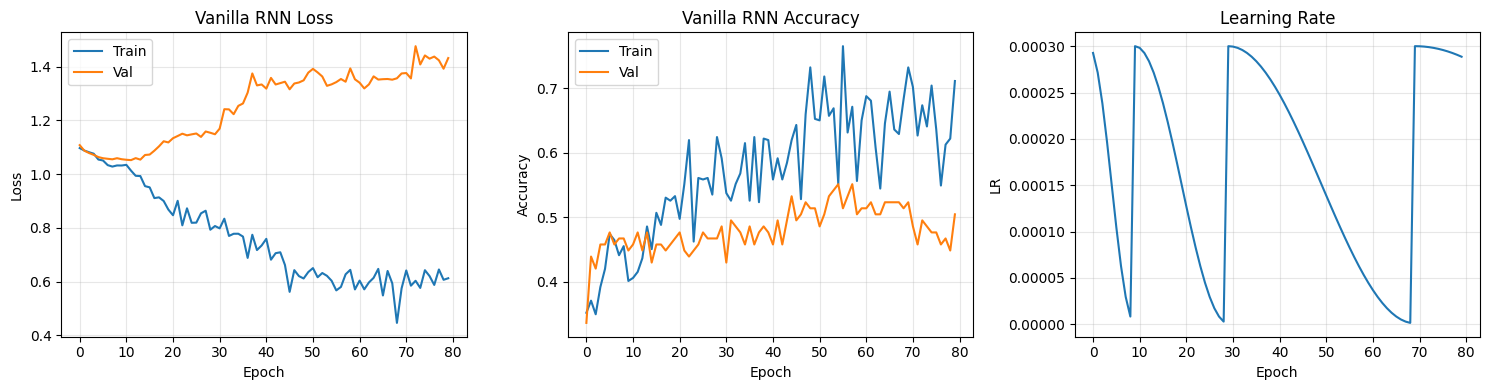

In [10]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Vanilla RNN Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_title('Vanilla RNN Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(history['learning_rate'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('LR')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.MODEL_DIR / 'rnn_training_history.png', dpi=150)
plt.show()

## 11. Final Evaluation

Loading best Vanilla RNN model...
Loaded model from epoch 55
Val F1: 0.5373, Val Acc: 0.5514


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]




Vanilla RNN Validation Set Evaluation

Metrics:
  Accuracy:       0.5514
  Precision:      0.5531
  Recall:         0.5514
  F1 (weighted):  0.5507
  F1 (macro):     0.5373

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.47      0.52      0.49        27
        COPD       0.60      0.62      0.61        48
      Asthma       0.56      0.47      0.51        32

    accuracy                           0.55       107
   macro avg       0.54      0.54      0.54       107
weighted avg       0.55      0.55      0.55       107



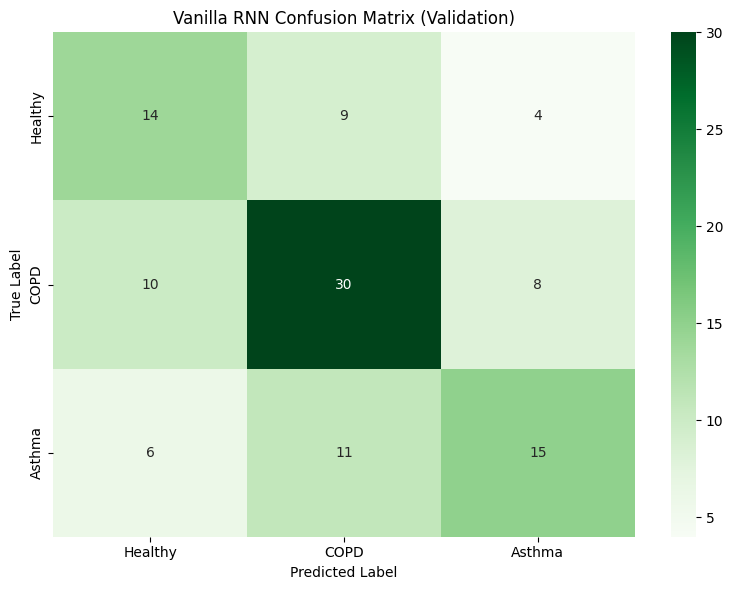

In [11]:
# Load best model
print("Loading best Vanilla RNN model...")
checkpoint = torch.load(config.MODEL_DIR / 'best_rnn_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Val F1: {checkpoint['val_f1']:.4f}, Val Acc: {checkpoint['val_acc']:.4f}")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(model, val_loader, criterion, device)
val_metrics = evaluate_model(val_labels, val_preds, title="Vanilla RNN Validation Set Evaluation")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['Healthy', 'COPD', 'Asthma'],
            yticklabels=['Healthy', 'COPD', 'Asthma'])
plt.title('Vanilla RNN Confusion Matrix (Validation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(config.MODEL_DIR / 'rnn_confusion_matrix.png', dpi=150)
plt.show()

## 12. Generate Predictions for Test Set

In [12]:
# Generate predictions for test set
print("Generating predictions for test set...")
model.eval()
test_preds = []
test_probs = []
test_candidate_ids = []

with torch.no_grad():
    for audio, lengths, candidate_ids in tqdm(test_loader, desc="Predicting"):
        audio = audio.to(device)
        
        outputs = model(audio, lengths)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_candidate_ids.extend(candidate_ids)

# Create predictions dictionary
predictions_dict = dict(zip(test_candidate_ids, test_preds))

# Handle missing candidates (use majority class = 2 as default)
all_test_candidates = test_df['candidateID'].tolist()
missing_candidates = [cid for cid in all_test_candidates if cid not in predictions_dict]

print(f"\nPredictions generated: {len(predictions_dict)}")
print(f"Missing candidates: {len(missing_candidates)}")

# Fill missing with majority class
for cid in missing_candidates:
    predictions_dict[cid] = 2  # Asthma as default

# Create submission
submission_df = pd.DataFrame({
    'candidateID': all_test_candidates,
    'disease': [predictions_dict[cid] for cid in all_test_candidates]
})

# Save submission
submission_path = config.BASE_PATH / 'submission_rnn.csv'
submission_df.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")

# Show prediction distribution
print(f"\nTest Prediction Distribution:")
pred_counts = submission_df['disease'].value_counts().sort_index()
for cls, count in pred_counts.items():
    class_name = ['Healthy', 'COPD', 'Asthma'][int(cls)]
    print(f"  Class {cls} ({class_name}): {count} ({count/len(submission_df)*100:.1f}%)")

print(f"\n✓ Vanilla RNN model training and prediction complete!")

Generating predictions for test set...


Predicting:  64%|██████▎   | 14/22 [00:02<00:01,  6.34it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/c7288373c8b33/vowel.wav'


Predicting:  86%|████████▋ | 19/22 [00:03<00:00,  6.19it/s]

Error loading /mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav: [Errno 2] No such file or directory: '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel_1/ea49e069ef645/vowel.wav'


Predicting: 100%|██████████| 22/22 [00:03<00:00,  6.30it/s]


Predictions generated: 338
Missing candidates: 0

Submission saved to: /mnt/ml_storage/Final_Project/SOURCE2/submission_rnn.csv

Test Prediction Distribution:
  Class 0 (Healthy): 125 (37.0%)
  Class 1 (COPD): 119 (35.2%)
  Class 2 (Asthma): 94 (27.8%)

✓ Vanilla RNN model training and prediction complete!


## 13. Model Comparison Summary

In [13]:
# Summary comparison
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print("\nVanilla RNN vs LSTM vs GRU:")
print("-"*60)
print(f"{'Model':<15} {'Gates':<10} {'Parameters':<15} {'Long Sequences':<15}")
print("-"*60)
print(f"{'Vanilla RNN':<15} {'None':<10} {'Fewest':<15} {'Poor (vanishing gradients)':<15}")
print(f"{'GRU':<15} {'2':<10} {'Medium':<15} {'Good':<15}")
print(f"{'LSTM':<15} {'3':<10} {'Most':<15} {'Best':<15}")
print("-"*60)
print("\nThis Vanilla RNN Model:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Best Validation F1: {best_f1:.4f}")
print(f"  - Best Validation Accuracy: {best_val_acc:.4f}")
print("\nNote: Vanilla RNN may underperform LSTM/GRU on this task due to")
print("vanishing gradient issues with longer audio sequences.")

MODEL COMPARISON SUMMARY

Vanilla RNN vs LSTM vs GRU:
------------------------------------------------------------
Model           Gates      Parameters      Long Sequences 
------------------------------------------------------------
Vanilla RNN     None       Fewest          Poor (vanishing gradients)
GRU             2          Medium          Good           
LSTM            3          Most            Best           
------------------------------------------------------------

This Vanilla RNN Model:
  - Total parameters: 237,812
  - Best Validation F1: 0.5373
  - Best Validation Accuracy: 0.5514

Note: Vanilla RNN may underperform LSTM/GRU on this task due to
vanishing gradient issues with longer audio sequences.
